In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Practical hack to work effectively with measured statistical distributions?

We take the empirical CDF of an array, put a linear interpolation through it, and pretend it is a continuous distribution which we feed to _scipy.stats_ which then allows us to get pdf's, sample from the distribution, etc. 
It is mostly intended for situations where one has a very large data set with say millions or even billions of points. 
Working with the fitted CDF is then less cumbersome. 
We also implement a way to choose logarithmic spacing of the interpolation points allowing to preserve the tails of the empirical CDF and survival function, which is particularly helpful when looking at the logarithm of peaked CDFs. 

Is this a useful? Even if it is not pretty? Is there a much better way?

In [2]:
import scipy.stats as stats
from SEdist import SE_distribution

Let's make a simple random field

In [3]:
Ns = 100000
rv = np.random.normal(2,1.5,Ns)   # Gaussian with mean 2 and variance 1.5
SEdist_u = SE_distribution(rv)    # Create a continuous distribution object from this empirical data

In [4]:
SEdist_u.N, SEdist_u.Nfit, len(SEdist_u.f.x) # the number of points in the interpolating function is the same as the input array

(100000, 100000, 100000)

In [5]:
SEdist = SE_distribution(rv,compress="linear", Ninterpolants=1000)    # Create a distribution object from this empirical data and compress the data using 1000 points
SEdist.N, SEdist.Nfit, len(SEdist.f.x) # the number of points in the interpolating function is much smaller than the input array

(100000, 1000, 1000)

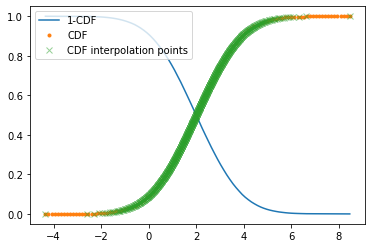

In [6]:
x = np.linspace(SEdist.a,SEdist.b, 100)
plot(x, SEdist.sf(x), label="1-CDF")
plot(x, SEdist.cdf(x), '.', label="CDF")
plot(SEdist.f.x, SEdist.f.y, 'x', label="CDF interpolation points", lw=5, alpha=.5)
legend();

This worked well and we now have the emipircal data in a small objects behaving as a smooth "continuous distribution". If we plot the data we can see by only using every 100th point we lost the extreme tails. Which is suboptimal if we think there may be interesting information there. 

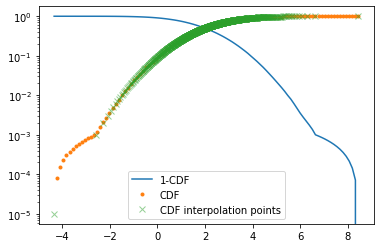

In [7]:
x = np.linspace(SEdist.a,SEdist.b, 100)
plot(x, SEdist.sf(x), label="1-CDF")
plot(x, SEdist.cdf(x), '.', label="CDF")
plot(SEdist.f.x, SEdist.f.y, 'x', label="CDF interpolation points", lw=5, alpha=.5)
yscale("log")
legend();

We insist on linear interpolation in the CDF. So for exponential tails we use logarithmic spacing of the samples in the CDF but symmetric around the median value to preserve both tails using the keyword *compress="log"*

In [8]:
lSEdist = SE_distribution(rv,compress="log")    # Create a distribution object from this empirical data and 

/Users/tabel/Research/Current/Phil/SEdist.py:97: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pcdf(*args))
/Users/tabel/Research/Current/Phil/SEdist.py:97: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pcdf(*args))
/Users/tabel/Research/Current/Phil/SEdist.py:97: RuntimeWarning: divide by zero encountered in log
  return np.log(self.pcdf(*args))


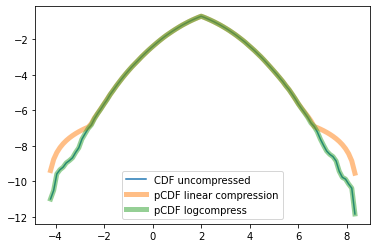

In [9]:
loc = SEdist.mean()
scale = SEdist.var()**0.5
fnorm = stats.norm(loc=loc,scale=scale)

x = np.linspace(SEdist.a,SEdist.b, 100)
plot(x, SEdist_u.logpcdf(x), label="CDF uncompressed")
plot(x, SEdist.logpcdf(x), label="pCDF linear compression", lw=5, alpha=.5)
plot(x, lSEdist.logpcdf(x), label="pCDF logcompress", lw=5, alpha=.5)
#plot(x, fnorm.logpcdf(x), label="CDF fitted normal", lw=3, alpha=.5)
plot()
legend();


In [10]:
x

array([-4.34415181, -4.21484292, -4.08553404, -3.95622515, -3.82691627,
       -3.69760738, -3.5682985 , -3.43898961, -3.30968073, -3.18037184,
       -3.05106295, -2.92175407, -2.79244518, -2.6631363 , -2.53382741,
       -2.40451853, -2.27520964, -2.14590076, -2.01659187, -1.88728299,
       -1.7579741 , -1.62866522, -1.49935633, -1.37004745, -1.24073856,
       -1.11142968, -0.98212079, -0.85281191, -0.72350302, -0.59419414,
       -0.46488525, -0.33557637, -0.20626748, -0.0769586 ,  0.05235029,
        0.18165917,  0.31096806,  0.44027694,  0.56958583,  0.69889471,
        0.8282036 ,  0.95751248,  1.08682137,  1.21613025,  1.34543914,
        1.47474802,  1.60405691,  1.73336579,  1.86267468,  1.99198356,
        2.12129245,  2.25060133,  2.37991022,  2.5092191 ,  2.63852799,
        2.76783687,  2.89714576,  3.02645464,  3.15576353,  3.28507241,
        3.4143813 ,  3.54369018,  3.67299907,  3.80230795,  3.93161684,
        4.06092572,  4.19023461,  4.31954349,  4.44885238,  4.57

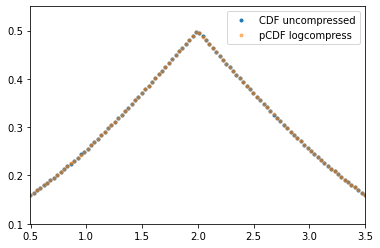

In [11]:
x = np.linspace(SEdist.mu- 1.*SEdist.std(),SEdist.mu+ 1.*SEdist.std(), 100)
plot(x, SEdist_u.pcdf(x), '.',label="CDF uncompressed")
#plot(x, SEdist.pcdf(x), label="pCDF linear compression", lw=5, alpha=.5)
plot(x, lSEdist.pcdf(x), '.', label="pCDF logcompress", lw=5, alpha=.5)
plot()
xlim(SEdist.mu- SEdist.std(),SEdist.mu+ 1*SEdist.std())
ylim(.1,.55)
legend();

In [12]:
SEdist_u.mean(),SEdist_u.var(),SEdist_u.std() # mean, variance and stdev

(1.9981723328602428, 2.2555200991395, 1.5018389058549189)

It knows its interval of validity.

In [13]:
lSEdist.a, lSEdist.b

(-4.344151805137327, 8.457427811267912)

and the interpolations points of the empirical CDF used to construct it. These are chosen to keep the tails intact.

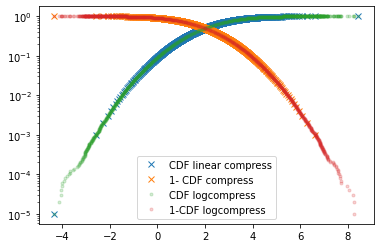

In [14]:
semilogy(SEdist.f.x, SEdist.f.y,'x', label="CDF linear compress",alpha=1)
plot(SEdist.f.x, 1-SEdist.f.y,'x', label="1- CDF compress",alpha=1);
plot(lSEdist.f.x, lSEdist.f.y,'.', label="CDF logcompress",alpha=.2);
plot(lSEdist.f.x, 1-lSEdist.f.y,'.', label="1-CDF logcompress",alpha=.2)
legend();


The integral of the pdf is reasonably close to 1 in this example

In [35]:
from scipy.integrate import quad
quad(SEdist.pdf, SEdist.a, SEdist.b, limit=200, epsabs=.01,epsrel=.001)

(0.99671568879883, 0.008139066649547999)

In [38]:
quad(lSEdist.pdf, lSEdist.a, lSEdist.b, limit=200, epsabs=.01,epsrel=.01)

(0.9997546690651758, 0.006236781563982441)

We can draw now random variates from that distribution (and quite efficiently) and compare it with the pdf

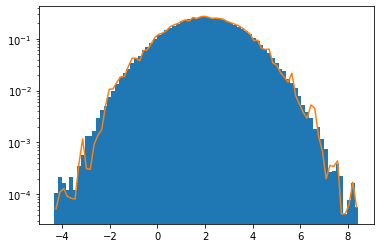

In [39]:
h = hist(lSEdist.rvs(size=3000000),bins=80,density=True)
bc =((h[1][1:]+h[1][0:-1])/2)[:]
plot(bc,lSEdist.pdf(bc))
yscale("log")

In [40]:
%timeit lSEdist.rvs(size=1000000) #a million random variates take about 70 ms on a mac laptop (2021) 

69.2 ms ± 941 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


Plotting only at the locations of the percentile function (inverse of CDF)

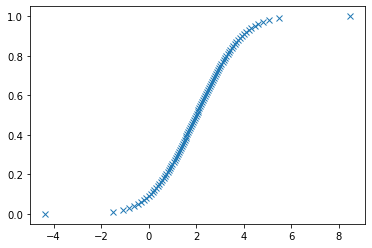

In [41]:
xpp = SEdist.ppf(np.linspace(0,1,100))
plot(xpp, SEdist.cdf(xpp),'x');

The essential trick is that we do many interpolation points at the tails and much fewer in the middle to compress the information down:


Here a lognormal version

In [42]:
nss = 10**((fnorm.rvs(size=Ns)))
lnSE = SE_distribution(nss)

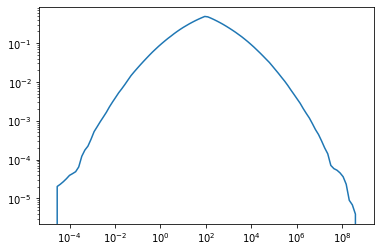

In [43]:
xp = np.logspace(np.log10(lnSE.a),np.log10(lnSE.b), 100)
loglog(xp,lnSE.pcdf(xp));

In [22]:
nss = np.random.uniform(0,1,Ns)
uSE = SE_distribution(nss,compress="log")

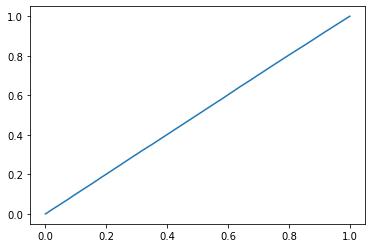

In [23]:
plot(uSE.f.x, uSE.cdf(uSE.f.x))

In this form though it is not ideal for pdf estimates. It gets noisy where the interpolations points are close. This certainly can be improved. However, what the "best" choice is questionable as any "histogramming" would be. E.g.

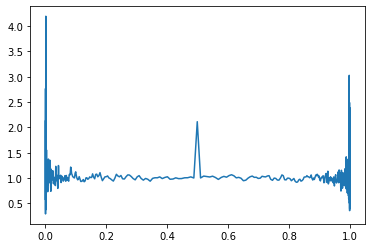

In [24]:
plot(uSE.f.x, uSE.pdf(uSE.f.x))